### The Long and Short of Climate Variability: a Stochastic Modelling Perspective

#### Background

#### Application

To apply the theory laid out by Frankignoul & Hasselman (1976) in this notebook, you'll need several tools. The first are python packages for computation (**numpy**, **pandas**, and the homebrewed **fh76_utilities**) and analysis (**seaborn** and **maplotlib**). As part of this repository, you should be able to construct the necessary computing environment via the accompanying **environment.yml** file:

In [ ]:
# If you have not created the computing environment for this notebook, uncommment and run this cell.
# ! conda env create -f environment.yml

Once you have the required environment, you should be good to go!

*Disclaimer: The only eyes on this so far have been my own. Proceed at your own risk.*


In [1]:
# Import the necessary libraries
import fh76_utilities as fh76
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn plotting aesthetics as default
sns.set_theme(context='notebook', style='darkgrid')

#### Example 1: Just a Coin Flip

FH76 conclude that the climate system can be described simplistically as a **white-noise generator coupled to a first-order Markov integrator.** 

Phew. That's some obtuse language. To build some intuition, let's start with everyone's favorite super-simple statistical case-study: a coin flip. 

A coin flip will have one of two outcomes (heads or tails) and that outcome is completely unpredictable, because each flip is a discrete event that has no memory of the previous flip. Thus, **a coin flip can be thought of as a white noise process**: a timeseries of coin flips would be sequence of unrelated, random outcomes with a mean of zero and limited variance.

If we assign a value to each outcome-- 1 for heads, -1 for tails-- we can track the cumulative distribution of coin flips over time as a numerical value. 

**Pause: if you are new to this idea, take a second to think about the cumulative distribution of coin flips. Do you expect that it will also be a sequence of unrelated, random outcomes?**

Once you've pondered to heart's content, let's flip some coins. 

Let's say that each day for 512 days in a row, you flip a coin once at midnight and once at midday and record the results. The following cell will mimic that process.

In [20]:
# Flip coins n number of times 
n = 2*512
flips = fh76.coin_flips(n)

# Calculate the cumulative sum of flips over time
flip_sum = np.cumsum(flips)

Now, let's take a look at the distributions of our coin flips and their cumulative sum.

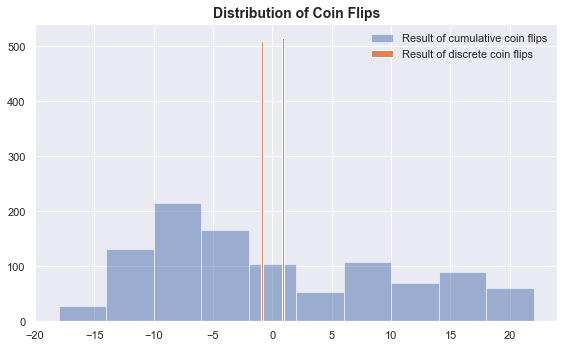

In [28]:
# intialize a figure
plt.figure(figsize=(8,5))

# plot the histogram of cumulative coin flips (valued -1 for tails and 1 for heads)...
plt.hist(flip_sum, alpha = 0.5, label = 'Result of cumulative coin flips')
# ... and discrete coin flips.
plt.hist(flips, label='Result of discrete coin flips')

# tailor and label the figure 
plt.legend(frameon=False)
plt.title('Distribution of Coin Flips', fontweight='bold', fontsize=14)
plt.tight_layout()

The orange bars represent an expected result- we have a basically even discrete distribution between flips that came up heads (1) and flips that came up tails (-1). The blue bars are also an expected result, but perhaps a slighly less intiutive one. 

By adding up the values associated with each coin flip (integrating over the sequence), we are transforming the binary outcome of a coin flip into a non-binary random walk, or adding memory to the system. This memory has no effect on the outcome of the next coin flip, but it does dictate the evolution of the cumulative sum. Even though each coin flip has a 50% chance of coming up heads, the results are totally unpredictable. There's no reason to expect that after a coin comes up heads, the next one will come up tails. If several coin flips in a row come up heads, for example, the cumulative "sum" of the coin flips will begin to wander away from the inital range [-1, 1]. 

This can be better visualized by plotting the timeseries of each individual result (orange) and of the cumulative total after each flip(blue), below.

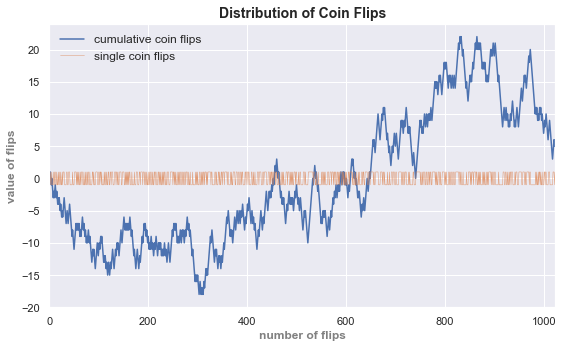

In [22]:
# initialize a figure 
plt.figure(figsize=(8,5))

# plot the cumulative sum after each flip
plt.plot(flip_sum, label='cumulative coin flips')

# plot the timeseries of each discrete flip
plt.plot([x for x in flips], linewidth=0.5, alpha=0.8, label = 'single coin flips')

# tailor and label the figure
plt.xlim([0,2*512])
plt.xlabel('number of flips',fontsize=12, fontweight='bold', color='grey')
plt.ylabel('value of flips',fontsize=12, fontweight='bold', color='grey')
plt.legend(frameon=False, fontsize=12)
plt.title('Distribution of Coin Flips', fontweight='bold', fontsize=14)
plt.tight_layout()

FH76 make the argument that the climate system behaves like these coin flips-- that the atmosphere produces a white-noise (stochastic, unpredictable) forcing and that the ocean mixed layer, which has some heat capacity, can remember the effect that forcing had on the sea surface temperature. It will therefore add the effect of each atmospheric perturbation to SST to the impact of the previous one, in effect **integrating the white noise over time**.

We'll explore this idea more in depth in the next example.

**Pause: FH76 present this model for global mean SST, using stochastic wind forcings associated with the mid-latitudes. What critiques come to mind? What possible extensions of their theory?**

#### Example 2: Simplified FH76

The atmosphere utilized by FH76 takes the form of a "barotropic model of quasi-geostrophic turbulence... in large-scale motions at equilibrium." The result is a statistically stationary wind timeseries, from which heat fluxes from the atmopshere to the ocean are inferred by bulk transfer formulae (representing how heat transfer is accomplished through the bulk motion of many molecules in a liquid or gas). 

We skip some of that nuance here and employ a homebrewed function to generate a pair of stationary timeseries for U (zonal wind) and V (meridional wind). The function takes as arguments two autocorrelation values (x_corr for U, y_corr for V) for wind at 12 hours timesteps, a length of the desired timeseries, and a mean zonal wind estimate. 

In [8]:
# Generate U, V (autocorr values from Sarkar et al., 2002)
U, V = fh76.generate_wind(x_corr=0.25, y_corr=0.25, len=2*512, mean_z_wind=10)

We can then supply the FH76 model with the required wind field. Our first experiment is the simplistic case initially presented in their paper:
- a 12-hour timestep
- a mixed layer depth of 25m
- a heat transfer parameterization coefficient of 0.25
- no feedbacks

We can then examine (a) the wind forcing, (b) the "event result" of each forcing (think of individual coin flips) on the sea surface temperature, and (c) the cumulative SST evolution as a result of the forcing.

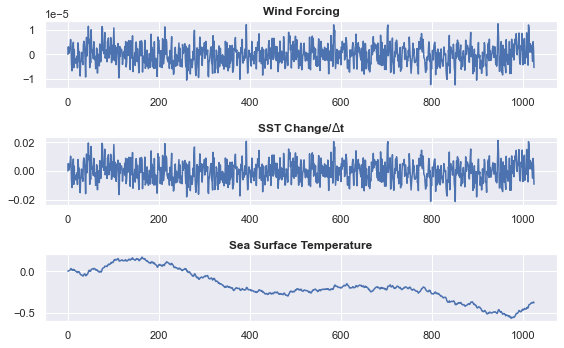

In [9]:
T, forcing, change = fh76.model(U, V, t=60*60*12, h=25, K=0.25, feedback=False, plot=True)

#### Question 1: Feedback Effects

In [ ]:
T_fb, forcing_fb, change_fb = fh76.model(U, V, t=60*60*12, h=25, K=0.25, feedback=True, plot=False)

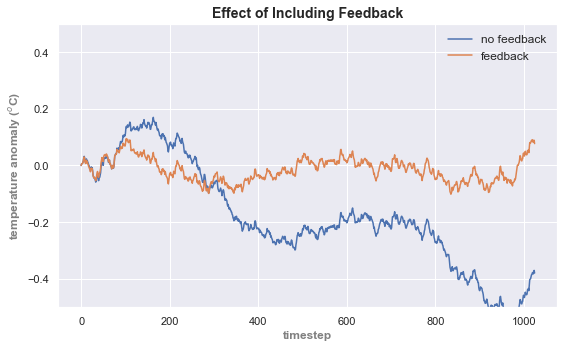

In [10]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=T, label='no feedback')
sns.lineplot(data=T_fb, label='feedback')

plt.legend(frameon=False, fontsize=12)
plt.title('Effect of Including Feedback', fontsize=14, fontweight='bold')
plt.ylim([-0.5, 0.5])
plt.xlabel('timestep', fontweight='bold', fontsize=12, color='grey')
plt.ylabel('temperature anomaly ($^o$C)', fontweight='bold', fontsize=12, color='grey')
plt.tight_layout()

#### Question 2: Mixed Layer Depth Dependency

In [11]:
depths = np.arange(10,110,10)

temps = []
for h in depths:
    T, forcing, change = fh76.model(U,V,h=h,plot=False)
    temps.append(T)
temps = np.array(temps)

data = pd.DataFrame(data=temps.transpose(), columns = depths)
# data

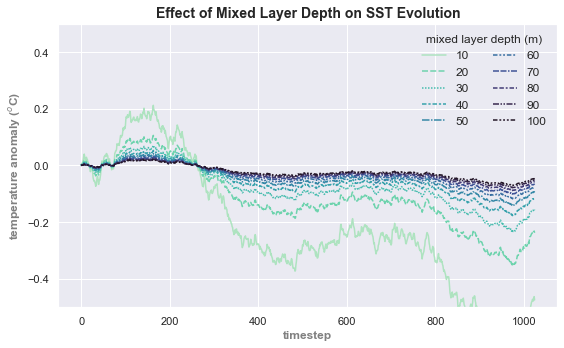

In [12]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=data,palette='mako_r', lw=1.5, linestyle='solid')
plt.legend(frameon=False, title='mixed layer depth (m)', ncol=2, fontsize=12)
plt.title('Effect of Mixed Layer Depth on SST Evolution', fontsize=14, fontweight='bold')
plt.ylim([-0.5, 0.5])
plt.xlabel('timestep', fontweight='bold', fontsize=12, color='grey')
plt.ylabel('temperature anomaly ($^o$C)', fontweight='bold', fontsize=12, color='grey')
plt.tight_layout()

#### Question 3: Heat Transport Parameterization Dependency

In [13]:
temps = []
consts = [x for x in np.linspace(0.1,1,10)]
for K in consts:
    T, forcing, change = fh76.model(U,V,K=K,plot=False)
    temps.append(T)
temps = np.array(temps)

data = pd.DataFrame(data=temps.transpose(), columns = np.round(consts, 3))
# data

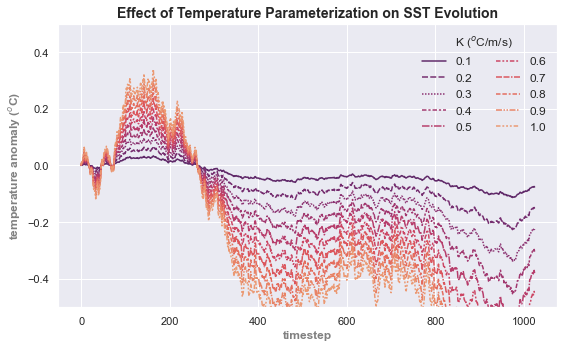

In [14]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=data,palette='flare_r', lw=1.5, linestyle='solid')
plt.legend(frameon=False, title='K ($^o$C/m/s)', ncol=2, fontsize=12)
plt.title('Effect of Temperature Parameterization on SST Evolution', fontsize=14, fontweight='bold')
plt.ylim([-0.5, 0.5])
plt.xlabel('timestep', fontweight='bold', fontsize=12, color='grey')
plt.ylabel('temperature anomaly ($^o$C)', fontweight='bold', fontsize=12, color='grey')
plt.tight_layout()